In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 33.2 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=bfbd40eb90114b9698326978236b8de71e0eb1b61120027044fbb69c63003b24
  Stored in directory: /root/.cache/pip/wheels/f3/e3/f2/1de1c2e3ed742e1df73e0f15d58864e50c7e64f607b548d6cf
Successfully built emoji


In [ ]:
!pip install pytest-warnings

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 9.8 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=cf4d24639681585f3268c0cc3d3ba9e8063bc0680b4caf0f835d466c74460fdb
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [ ]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# library yang dibutuhkan

from textwrap import wrap

import emoji
import joblib
import langdetect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
def get_category_dict(category_file):
  category = pd.read_json(category_file, orient="record")
  category = pd.DataFrame(category["items"].values.tolist())

  return{
      cat.id: cat.snippet.get("title")
      for cat in category.itertuples(index=False)
  }

In [ ]:
category_dict = get_category_dict("/content/drive/MyDrive/Colab Notebooks/data/category.json")

In [ ]:
trending = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/trending.csv", parse_dates=["publish_time", "trending_time"])

with pd.option_context("display.max_columns", None):
  display(trending.head())

In [ ]:
start_date = trending.trending_time.min()
end_date = trending.trending_time.max()

print(f"start date = {start_date }")
print(f"end date = {end_date }")

start date = 2021-02-07 05:46:51.832614+00:00
end date = 2022-11-19 06:02:12.845027+00:00


In [ ]:
#delete data bulan feb-juni

filtered_trending = trending[trending.trending_time.dt.month >= 7]

start_date = filtered_trending.trending_time.min()
end_date = filtered_trending.trending_time.max()

print(f"start date = {start_date }")
print(f"end date = {end_date }")

start date = 2021-07-01 06:01:25.524449+00:00
end date = 2022-11-19 06:02:12.845027+00:00


In [ ]:
num_videos = filtered_trending.shape[0]
print(f"num videos = {num_videos }")


num videos = 63718


In [ ]:
#distribusi missing value
filtered_trending.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63718 entries, 21322 to 118750
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   video_id           31918 non-null  object             
 1   publish_time       63718 non-null  datetime64[ns, UTC]
 2   channel_id         63718 non-null  object             
 3   title              63718 non-null  object             
 4   description        61486 non-null  object             
 5   thumbnail_url      31918 non-null  object             
 6   thumbnail_width    31918 non-null  float64            
 7   thumbnail_height   31918 non-null  float64            
 8   channel_name       63718 non-null  object             
 9   tags               55466 non-null  object             
 10  category_id        63718 non-null  int64              
 11  live_status        63718 non-null  object             
 12  local_title        63718 non-null  object

In [ ]:
#delete video dengan deskripsi kosong

filtered_trending.dropna(subset=["description"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
trending_by_date = filtered_trending.groupby(
    filtered_trending.trending_time.dt.date
)
num_trending_per_day = trending_by_date.trending_time.count()
print("Number of vidioes in trending per day:", num_trending_per_day.unique())

Number of vidioes in trending per day: [195 196 197 198 194 193 192 191 190 188 187 185 189 186 184 183 132 182
 181 179 176 172 155 144 149 148 141 140 131 129 145 167 163 157 156 175
 169 199 200]


In [ ]:
trending_duration = filtered_trending.groupby("title").agg(
    trending_duration=pd.NamedAgg(column="trending_time", aggfunc="count"),
    trending_start_date = pd.NamedAgg(column="trending_time", aggfunc="min"),
    trending_last_date = pd.NamedAgg(column="trending_time", aggfunc="max")
).sort_values("trending_duration", ascending=False).reset_index()

In [ ]:
trending_duration.head(10)

,title,trending_duration,trending_start_date,trending_last_date
0,"JEJE PENGHUNI STASIUN DUKUH ATAS, PERNAH CABUT...",37,2022-07-02 06:01:31.621150+00:00,2022-08-07 06:01:00.607537+00:00
1,Toleransi antar tetangga di Korea🇰🇷.. 🤦🏻‍♂️,37,2022-07-02 06:01:31.621606+00:00,2022-08-07 06:01:00.607651+00:00
2,"NEGO 1 GEROBAK SHAWARMA VIRAL DI TIKTOK, SAMPE...",36,2022-07-08 06:01:39.900318+00:00,2022-08-12 06:01:33.892049+00:00
3,"Tantangin VYN Pake Franco, 1 Kali Kena Hook Da...",35,2022-07-01 06:01:38.284040+00:00,2022-08-04 06:02:04.519603+00:00
4,OPW ARES Sudah Tamat,35,2022-07-02 06:01:31.621296+00:00,2022-08-05 06:02:43.644196+00:00
5,SINGAPORE STREET FOOD #08,35,2022-07-02 06:01:31.621620+00:00,2022-08-06 06:02:02.694750+00:00
6,Kok di Indonesia ada penjual Rawon yg lebih pi...,34,2022-07-02 06:01:31.621592+00:00,2022-08-04 06:02:04.519738+00:00
7,SELAMAT LEBARAN GUYS!!!,33,2022-07-11 06:00:59.413948+00:00,2022-08-12 06:01:33.891919+00:00
8,gak bisa bahasa enggres,32,2022-07-01 06:01:38.284013+00:00,2022-08-01 06:01:08.899895+00:00
9,"HANYA FARIDA NURHAN, MUKBANG MIE GACOAN LEVEL ...",32,2022-07-11 06:00:59.414152+00:00,2022-08-11 06:01:46.801212+00:00


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127479 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129318 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127995 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127472 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127479 missing from current font.
  font.

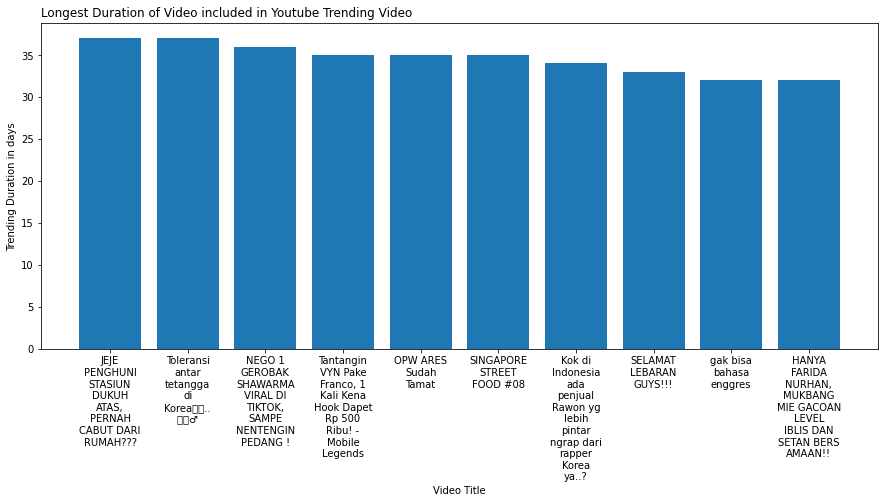

In [ ]:
# visualisasi trending pakai chart

plt.figure(figsize=(15,6))
plt.bar(
    trending_duration.title[:10].apply(lambda title: "\n".join(wrap(title, width=10))),
    trending_duration.trending_duration[:10]
)

plt.title("Longest Duration of Video included in Youtube Trending Video", loc="left")
plt.xlabel("Video Title")
plt.ylabel("Trending Duration in days")
plt.grid(False)
plt.show()

In [ ]:
trending_by_title = filtered_trending.groupby("title")
trending_rewind = trending_by_title[["view", "like", "dislike"]].agg(["min","max","mean","sum"])
trending_rewind

view             \
                                                          min        max   
title                                                                      
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...   101823.0   121044.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2280620.0  2637486.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    72434.0   116310.0   
"Grebek rumah harris vriza, dan percintaannya d...    68879.0   163773.0   
"Hellevator" Band Cover By Xdinary Heroes (원곡 :...   393043.0  1348612.0   
...                                                       ...        ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   148668.0   680210.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...   330156.0  7334655.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   278942.0  1212522.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   320084.0  1097903.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  1423178.0  2966798.0   

                                                                              \
                                                            mean         sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...  1.114335e+05    222867.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2.459053e+06   4918106.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...  9.390625e+04    375625.0   
"Grebek rumah harris vriza, dan percintaannya d...  1.267565e+05    760539.0   
"Hellevator" Band Cover By Xdinary Heroes (원곡 :...  1.126182e+06  14640369.0   
...                                                          ...         ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...  5.519997e+05   8831995.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...  3.414214e+06  34142143.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.948737e+05   5564116.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.562497e+05   4537498.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  2.629831e+06  36817634.0   

                                                        like            \
                                                         min       max   
title                                                                    
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1336.0    1456.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   93348.0  101207.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...     990.0    1432.0   
"Grebek rumah harris vriza, dan percintaannya d...    5529.0    8714.0   
"Hellevator" Band Cover By Xdinary Heroes (원곡 :...  127824.0  262846.0   
...                                                      ...       ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   39847.0  101922.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...    2822.0   58066.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    2790.0   10212.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    3025.0    8759.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  316849.0  457809.0   

                                                                              \
                                                             mean        sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1396.000000     2792.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   97277.500000   194555.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    1228.500000     4914.0   
"Grebek rumah harris vriza, dan percintaannya d...    7486.833333    44921.0   
"Hellevator" Band Cover By Xdinary Heroes (원곡 :...  237112.769231  3082466.0   
...                                                           ...        ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   87227.125000  1395634.0   
🥰 New Gadgets & Versatile Utensils

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53444 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128156 missing from current font.
  font.set

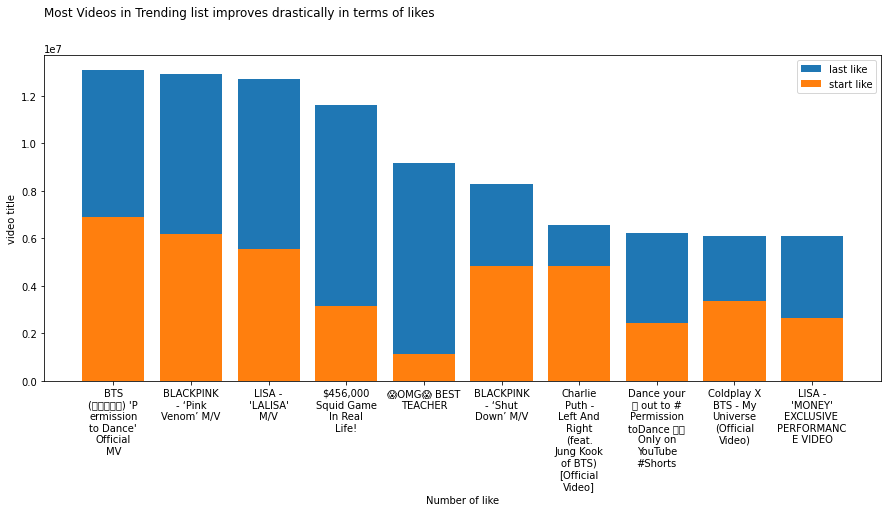

In [ ]:
# visualisasi trending video

top_10_liked = trending_rewind["like"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15,6))
plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["max"],
    label="last like"
)

plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["min"],
    label="start like"
)

plt.title("Most Videos in Trending list improves drastically in terms of likes", loc="left", y=1.1)
plt.xlabel("Number of like")
plt.ylabel("video title")
plt.legend()
plt.grid(False)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129315 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129315 missing from current font.
  font.set_text(s, 0, flags=flags)


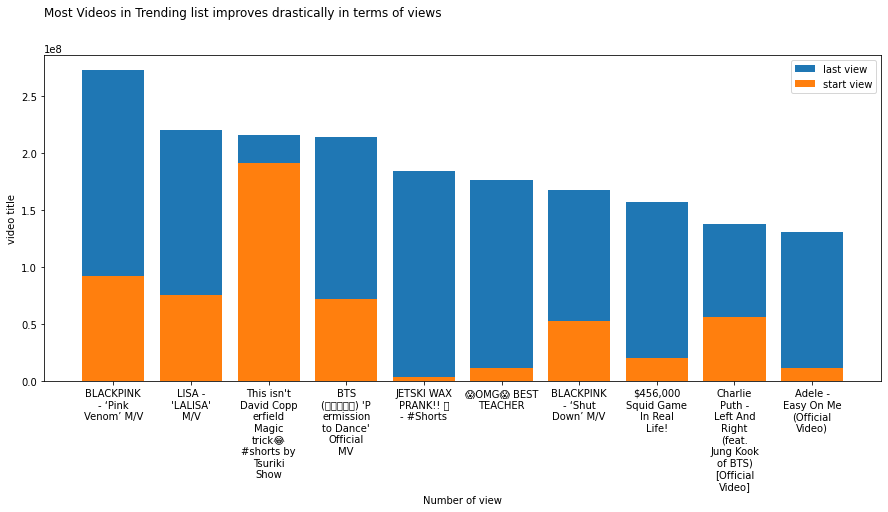

In [ ]:
# visualisasi trending video view

top_10_viewed = trending_rewind["view"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15,6))
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["max"],
    label="last view"
)

plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["min"],
    label="start view"
)

plt.title("Most Videos in Trending list improves drastically in terms of views", loc="left", y=1.1)
plt.xlabel("Number of view")
plt.ylabel("video title")
plt.legend()
plt.grid(False)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128184 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9969 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127925 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128184 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9969 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127925 missing from current font.
  font.set_te

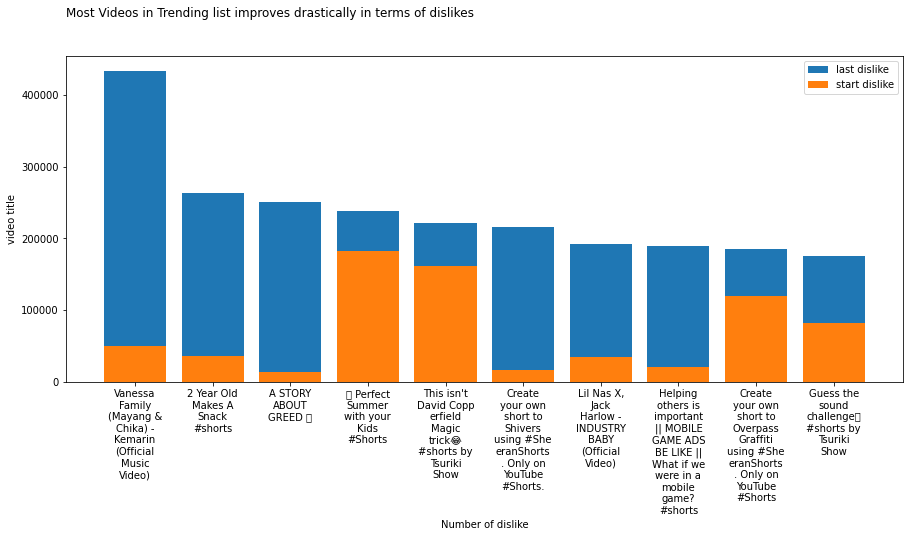

In [ ]:
# visualisasi trending video dislike

top_10_disliked = trending_rewind["dislike"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15,6))
plt.bar(
    top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_disliked["max"],
    label="last dislike"
)

plt.bar(
    top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_disliked["min"],
    label="start dislike"
)

plt.title("Most Videos in Trending list improves drastically in terms of dislikes", loc="left", y=1.1)
plt.xlabel("Number of dislike")
plt.ylabel("video title")
plt.legend()
plt.grid(False)
plt.show()

LANG DETECT

In [ ]:
sample = filtered_trending.sample(10, random_state=11)
sample[["title","description"]]

,title,description
50234,MAN CITY 3-0 EVERTON | PREMIER LEAGUE HIGHLIGHTS,Everton fell to defeat at Manchester City in a...
22694,Idgitaf - Berlagak Bahagia (Official Lyric Video),Berlagak Bahagia (Official Lyric Video)\nStrea...
93064,Seharian ngerasain kerjaan jadi SALES HP!,Boleh hape murah kaka...\n\nBarang bekas revie...
47387,UPDATE TERBARU VERSI 1.038.85!! MOTOR BARU LAN...,Hello guys..kita lanjut lagi main Sakura Schoo...
37865,Persaingan Pedagang Bakso – tebar tanah kubura...,Join this channel to get access to perks:\nhtt...
103946,"Melly Goeslaw, Lesti, Nagita Slavina, Celine E...","RUMAH KITA - MELLY GOESLAW, NAGITA SLAVINA, LE..."
53471,"KISAH HARU RUMINI, Meninggal Berpelukan Bersam...","SURYA.co.id, LUMAJANG - Korban meninggal letus..."
103941,EPIC Leon Edwards' coaches inspire him to incr...,Leon Edwards did the unthinkable by defeating ...
42589,TANTANGAN MENGHIAS KEIK || Putar Roda Misterin...,"Kalau kita membayangkan keik, kita pasti ngeba..."
107739,Teaser | Percy Jackson and the Olympians | Dis...,"For more updates, subscribe to Disney, Pixar, ..."


In [ ]:
# ubah jadi lowercase

sample["title_lang"] = sample.title.apply(lambda title: langdetect.detect(title.lower()))
sample["desc_lang"] = sample.description.apply(lambda title: langdetect.detect(title.lower()))

In [ ]:
with pd.option_context("display.max_colwidth",100):
  display(sample[["title", "title_lang","description","desc_lang"]])

,title,title_lang,description,desc_lang
50234,MAN CITY 3-0 EVERTON | PREMIER LEAGUE HIGHLIGHTS,en,Everton fell to defeat at Manchester City in a difficult afternoon at Etihad Stadium. Raheem Ste...,en
22694,Idgitaf - Berlagak Bahagia (Official Lyric Video),en,"Berlagak Bahagia (Official Lyric Video)\nStream ""Berlagak Bahagia"" in your favorite platform: ht...",en
93064,Seharian ngerasain kerjaan jadi SALES HP!,id,Boleh hape murah kaka...\n\nBarang bekas review biasanya saya jual disini: https://invol.co/cl75...,id
47387,UPDATE TERBARU VERSI 1.038.85!! MOTOR BARU LANGSUNG BUAT BALAPAN!! SAKURA SCHOOL SIMULATOR-PART 494,id,Hello guys..kita lanjut lagi main Sakura School Part 494 yaa. Kali ini Sakurani Review UPDATE T...,id
37865,Persaingan Pedagang Bakso – tebar tanah kuburan agar bangkrut #HORORMISTERI | Kartun hantu pocong,id,Join this channel to get access to perks:\nhttps://www.youtube.com/channel/UC7GWXKxiy9_AU9TytEh0...,id
103946,"Melly Goeslaw, Lesti, Nagita Slavina, Celine Evangelista - Rumah Kita | Official Music Video",it,"RUMAH KITA - MELLY GOESLAW, NAGITA SLAVINA, LESTI, CELINE EVANGELISTA\n#RumahKita #PulihLebihCep...",id
53471,"KISAH HARU RUMINI, Meninggal Berpelukan Bersama Ibunya Digulung Wedhus Gembel Semeru",id,"SURYA.co.id, LUMAJANG - Korban meninggal letusan Semeru mulai ditemukan. Dua di antaranya adalah...",id
103941,EPIC Leon Edwards' coaches inspire him to incredible comeback win! | Usman v Edwards 2 | UFC 278,en,Leon Edwards did the unthinkable by defeating Kamaru Usman and becoming the UFC welterweight Cha...,en
42589,TANTANGAN MENGHIAS KEIK || Putar Roda Misterinya! 100 Lapis MAKANAN oleh 123 GO! CHALLENGE,id,"Kalau kita membayangkan keik, kita pasti ngebayangin berlapis-lapis dengan cokelat manis, tabura...",id
107739,Teaser | Percy Jackson and the Olympians | Disney+,en,"For more updates, subscribe to Disney, Pixar, Marvel, Star Wars, and National Geographic.\n \nDi...",en


digunakan lowercase agar mempermudah detect language nya dengan maxxx

runningnya dari sini masih an

In [ ]:
# fungsi untuk detect bahasa

def detect_language(text):
  """Detect language of the `text`."""
  try:
    lang = langdetect.detect(text)
    return lang
  except:
    return

In [ ]:
filtered_trending["title_lang"] = filtered_trending["title"].apply(detect_language)
filtered_trending["desc_lang"] = filtered_trending["description"].apply(detect_language)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
filtered_trending[["title", "title_lang", "description","desc_lang"]]

,title,title_lang,description,desc_lang
21322,NCT DREAM 엔시티 드림 'Hello Future' MV,it,"NCT DREAM's 1st Album Repackage ""Hello Future""...",en
21323,PART 3 // SUTRISNO DAN ENDANG BAHAGIA,de,Find me on sosial media :\n\nInstagram : https...,en
21324,This isn't David Copperfield Magic trick😂 #sho...,en,Thank you for watching.\nSubscribe to Tsuriki ...,en
21325,Rizky Billar - Pemimpinmu | Official Music Video,en,Rizky Billar - Pemimpinmu | Official Music Vid...,id
21326,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,id,Polisi menangkap pengemudi SUV yang merusak da...,id
...,...,...,...,...
118746,NASI GORENG BAKAR INI PINDAH SAMPAI 13 KALI KA...,de,HAHHH JUALAN NASI GORENG INI UDAH 13 KALI PIND...,id
118747,"KENAL DEKAT DENGAN KELUARGA NATHALIE, PAPA SAY...",de,"Hi, welcome to Nathalie Holscher Channel!\n\nF...",id
118748,YOUNITE 'Bad Cupid' M/V,en,YOUNITE 'Bad Cupid' M/V\n\n'YOUNI-ON' Availabl...,en
118749,Cover | JAEHYUN - Can't Take My Eyes Off You (...,en,#Cover #JAEHYUN\n#CantTakeMyEyesOffYou #Franki...,en


In [ ]:
indo_trending = filtered_trending.loc[
    (filtered_trending.title_lang == "id") | (filtered_trending.desc_lang == "id")
]

with pd.option_context("display.max_columns", None):
  display(indo_trending.sample(10))

,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time,title_lang,desc_lang
104574,3iyHbndUxo0,2022-09-09 12:33:01+00:00,UC1Gmqqs_Myzl2KHIeqfUC9A,WASEDABOYS INDONESIA TRIP SELESAI...SAATNYA BE...,Konnijiwa! Terima kasih sudah nonton Wasedaboy...,https://i.ytimg.com/vi/3iyHbndUxo0/hqdefault.jpg,480.0,360.0,Nihongo Mantappu,"['nihongo mantappu', 'nihongo', 'mantappu', 'm...",22,none,WASEDABOYS INDONESIA TRIP SELESAI...SAATNYA BE...,Konnijiwa! Terima kasih sudah nonton Wasedaboy...,PT24M6S,2d,hd,False,True,NaN,NaN,239034.0,17435.0,NaN,0,979.0,2022-09-10 06:04:10.506242+00:00,en,id
55616,4PuhFQOLM1A,2021-12-12 13:58:29+00:00,UCwljrkoI5jsfvAKgW3zNC7Q,ALL STARS - WONDERLAND INDONESIA,"Sobat Shopee, setuju banget kan kalau penampil...",https://i.ytimg.com/vi/4PuhFQOLM1A/hqdefault.jpg,480.0,360.0,SHOPEE Indonesia,"['shopee 12.12 birthday sale tv show', 'shopee...",24,none,ALL STARS - WONDERLAND INDONESIA,"Sobat Shopee, setuju banget kan kalau penampil...",PT3M2S,2d,hd,False,False,NaN,NaN,347815.0,NaN,NaN,0,488.0,2021-12-20 06:01:35.472673+00:00,en,id
118546,fENU3CcDXpw,2022-10-30 12:00:08+00:00,UCAdbNpr8dj9UUsgYrqln7nQ,HAPPY ASMARA - TAK SELAMANYA SELINGKUH ITU IND...,Official Live Music From HAPPY ASMARA - TAK SE...,https://i.ytimg.com/vi/fENU3CcDXpw/hqdefault.jpg,480.0,360.0,RC Music,"['royal music', 'rc music', 'happy asmara', 't...",10,none,HAPPY ASMARA - TAK SELAMANYA SELINGKUH ITU IND...,Official Live Music From HAPPY ASMARA - TAK SE...,PT5M36S,2d,hd,True,True,NaN,NaN,981047.0,16783.0,NaN,0,1827.0,2022-11-18 06:02:03.664497+00:00,en,id
93892,zkM5ah0-vBY,2022-07-11 10:20:14+00:00,UCfRNJiafEm1LBBGFTTq4cXw,DETIK2 GEN HALILINTAR MENDARAT DI INDONESIA,"Sebagai tanda syukur Anniversary 27 tahun, Gen...",https://i.ytimg.com/vi/zkM5ah0-vBY/hqdefault.jpg,480.0,360.0,GEN HALILINTAR,"['genhalilintar', 'family', '11kids', 'unique'...",24,none,DETIK2 GEN HALILINTAR MENDARAT DI INDONESIA,"Sebagai tanda syukur Anniversary 27 tahun, Gen...",PT11M14S,2d,hd,False,True,NaN,NaN,2194694.0,96296.0,NaN,0,2565.0,2022-07-14 06:02:06.000589+00:00,de,id
99698,9sZ3dBD_kvE,2022-08-02 06:00:10+00:00,UChZJIRPxLqgcUGV1PFvf3ag,Edisi Grebek Rumah Mewah Lesty Billar! Koleksi...,Akhirnya Icip Icip DinaKekeWindy bisa main ke ...,https://i.ytimg.com/vi/9sZ3dBD_kvE/hqdefault.jpg,480.0,360.0,icip icip DinaKekeWindy,"['cut keke', 'windy ario', 'dina lorenza', 'ic...",23,none,Edisi Grebek Rumah Mewah Lesty Billar! Koleksi...,Akhirnya Icip Icip DinaKekeWindy bisa main ke ...,PT19M58S,2d,hd,False,True,NaN,NaN,260368.0,18190.0,NaN,0,976.0,2022-08-16 06:02:15.793794+00:00,tr,id
25461,NaN,2021-07-19 16:45:10+00:00,UC6GIiaWJxZyKk_CAVa6y54Q,MASTERCHEF INDONESIA - BANJIR AIR MATA!! Siapa...,Sudah Beri Kata-Kata Perpisahan Olivia Dan Jug...,NaN,NaN,NaN,MasterChef Indonesia,"['MasterChef Indonesia', 'RCTI', 'Chef Juna', ...",24,none,MASTERCHEF INDONESIA - BANJIR AIR MATA!! Siapa...,Sudah Beri Kata-Kata Perpisahan Olivia Dan Jug...,PT12M6S,2d,hd,False,True,NaN,NaN,512110.0,13410.0,187.0,0,2592.0,2021-07-21 06:01:23.252451+00:00,id,id
32224,NaN,2021-08-21 14:14:38+00:00,UCYqOeAXJm8yV9sJ8Ud3cR7A,"Duet Paling Ngehits!! Fildan DA-Lesti DA ""Geri...",Tonton tayangan lengkap Indosiar di vidio.com ...,NaN,NaN,NaN,Indosiar,"['indosiar', 'TAKDIR CINTA LESLAR']",24,none,"Duet Paling Ngehits!! Fildan DA-Lesti DA ""Geri...",Tonton tayangan lengkap Indosiar di vidio.com ...,PT5M53S,2d,hd,False,True,NaN,NaN,1522333.0,41965.0,739.0,0,2415.0,2021-08-24 06:01:02.598286+00:00,de,id
47774,NaN,2021-11-05 16:21:31+00:00,UCYqOeAXJm8yV9sJ8Ud3cR7A,KONTROVERSI! Penalti Marco Motta (Persija) yan...,Tonton tayangan lengkap Indosiar di vidio.com ...,NaN,NaN,NaN,Indosiar,['indosiar'],24,none,KONTROVERSI! Penalti Marco Motta (Persija) yan...,Tonton tayangan lengkap I

FUTURE EXTRACTION 

In [ ]:
data = indo_trending[["title", "description", "category_id"]].reset_index(drop=True)
data

,title,description,category_id
0,Rizky Billar - Pemimpinmu | Official Music Video,Rizky Billar - Pemimpinmu | Official Music Vid...,10
1,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,Polisi menangkap pengemudi SUV yang merusak da...,25
2,Aksi Demo Tolak Kedatangan Jokowi di Kendari B...,Tanggal Tayang: 30/06/2021\n\nProgram berita h...,25
3,"PERTAMA KALI LIAT SAPI SEGEDE GINI, DINAIKIN D...",Assalamualaikum gaeess..! sudah nonton video s...,15
4,PODKESMAS SAMPAI GA NYAMAN DIBAHAS DISINI - To...,Talk show malam yang akan memberikan informasi...,24
...,...,...,...
37976,Ariel NOAH x Enda Ungu - Yang Terdalam (Live a...,Ariel NOAH x Enda Ungu - Yang Terdalam\n\nOrig...,10
37977,Farel Prayoga Feat Dini Kurnia _CINTA TAK TERP...,Farel Prayoga Feat Dini Kurnia _CINTA TAK TERP...,10
37978,NASI GORENG BAKAR INI PINDAH SAMPAI 13 KALI KA...,HAHHH JUALAN NASI GORENG INI UDAH 13 KALI PIND...,22
37979,"KENAL DEKAT DENGAN KELUARGA NATHALIE, PAPA SAY...","Hi, welcome to Nathalie Holscher Channel!\n\nF...",24


DUPLICATES

In [ ]:
data.drop_duplicates(subset="title", inplace=True)

data.reset_index(drop=True, inplace=True)
data.shape

(6152, 3)

FEATURE ENGINEERING [EMIOJIII>

In [ ]:
# !pip install emoji

In [ ]:
# !pip install emoji

In [ ]:
# list_emoji = [e for e in emoji.UNICODE_EMOJI.get("en")]

list_emoji = [e for e in emoji.EMOJI_DATA]

count = 0

for em in list_emoji:
  for title in data.title:
    if em in title:
      count += 1
print("How many titles use emoji?", count)

How many titles use emoji? 784


ngetiknya dari : Ternyata ada 591 video yang judulnya.....

In [ ]:
def demojize(text):
  for em in list_emoji:
    if em in text:
      em_text = emoji.demojize(em)
      text = text.replace(em, " " + em_text + " ")
  return text

In [ ]:
data["title_emoji"] = data.title.apply(demojize)

In [ ]:
title_with_emoji_idx = [
    idx for idx in range(len(data.title))
    for em in list_emoji
    if em in data.loc[idx, "title"]
]

In [ ]:
with pd.option_context("display.max_colwidth", 100):
  display(data.loc[title_with_emoji_idx])

,title,description,category_id,title_emoji
34,Dari Jendela Smp : GREGETTT...Wih kelihatannya Wulan jadi primadona di SMA Merdeka Mandiri nih...❤,Saksikan #DariJendelaSMP Setiap Hari Pkl. 16.40 WIB hanya di @Surya Citra Televisi (SCTV) \n@sin...,24,Dari Jendela Smp : GREGETTT...Wih kelihatannya Wulan jadi primadona di SMA Merdeka Mandiri nih.....
79,BIKIN CEWEK TERPESONA 😍 Aksi Heroik Driver Muda Menolong Sopir Yang Kesulitan di Sitinjau Lauik,Aksi heroik driver muda membantu sopir minibus yang kesulitan di Sitinjau Lauik\n\ninstagram : h...,2,BIKIN CEWEK TERPESONA :smiling_face_with_heart-eyes: Aksi Heroik Driver Muda Menolong Sopir Ya...
81,15 MENIT MEMBAKAR LEMAK 1 Kg !!! 24 Jam TIMBANGAN TURUN ✅ ✅ ✅,"15 menit membakar lemak, ok ! siapa yg workout mengharapkan bisa membakar 1 kg lemak dalam 15 me...",26,15 MENIT MEMBAKAR LEMAK 1 Kg !!! 24 Jam TIMBANGAN TURUN :check_mark_button: :check_mark_butto...
148,"WHY‼️ SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast","#somasi #odgj #podcast\nTEMAN TEMAN KONTEN CREATOR, JANGAN TAKUT BERKARYA SELAMA TUJUAN KALIAN B...",24,"WHY :double_exclamation_mark: SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast"
148,"WHY‼️ SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast","#somasi #odgj #podcast\nTEMAN TEMAN KONTEN CREATOR, JANGAN TAKUT BERKARYA SELAMA TUJUAN KALIAN B...",24,"WHY :double_exclamation_mark: SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast"
...,...,...,...,...
6110,KITA BEREMPAT MAIN PETAK UMPET DI MAP BUATAN ISTRI 😁,- Subcribe Gratis : https://goo.gl/9DnNkc\n- Join TeguhTeam : https://www.youtube.com/channel/U...,20,KITA BEREMPAT MAIN PETAK UMPET DI MAP BUATAN ISTRI :beaming_face_with_smiling_eyes:
6118,Semoga HP ini LAKU KERAS 🙏🏻 - Review Zenfone 9 Indonesia,Udah lama ga muji HP sampe segininya.\n\nDapatkan pengalaman baru menikmati Kopi Kapal Api Speci...,28,Semoga HP ini LAKU KERAS :folded_hands: :light_skin_tone: - Review Zenfone 9 Indonesia
6118,Semoga HP ini LAKU KERAS 🙏🏻 - Review Zenfone 9 Indonesia,Udah lama ga muji HP sampe segininya.\n\nDapatkan pengalaman baru menikmati Kopi Kapal Api Speci...,28,Semoga HP ini LAKU KERAS :folded_hands: :light_skin_tone: - Review Zenfone 9 Indonesia
6118,Semoga HP ini LAKU KERAS 🙏🏻 - Review Zenfone 9 Indonesia,Udah lama ga muji HP sampe segininya.\n\nDapatkan pengalaman baru menikmati Kopi Kapal Api Speci...,28,Semoga HP ini LAKU KERAS :folded_hands: :light_skin_tone: - Review Zenfone 9 Indonesia


Karena kita sudah mendapatkan representasi emoji pada kolom title_emoji , kita tidak memerlukan kolom title lagi. Sehingga, kita
bisa buang kolom tersebut.

In [ ]:
# Delete kolom title
data.drop(columns="title", inplace=True)

Eksplorasi

In [ ]:
desc_with_emoji_idx = [
    idx for idx in range(len(data.description))
    for em in list_emoji
    if em in data.loc[idx, "description"]
]

data["desc_emoji"] = data.description.apply(demojize)

with pd.option_context("display.max_colwidth", 100):
  display(data.loc[desc_with_emoji_idx])

,description,category_id,title_emoji,desc_emoji
0,Rizky Billar - Pemimpinmu | Official Music Video\n\nSurprise Untuk Dede Lesti :\nhttps://youtu.b...,10,Rizky Billar - Pemimpinmu | Official Music Video,Rizky Billar - Pemimpinmu | Official Music Video\n\nSurprise Untuk Dede Lesti :\nhttps://youtu.b...
8,#LestiBawaAkuKePenghulu #Lesti #MusicVideo #LiveAcoustic\n\nAura bahagia semakin terpancar denga...,10,Lesti - Bawa Aku Ke Penghulu | Live Acoustic Version,#LestiBawaAkuKePenghulu #Lesti #MusicVideo #LiveAcoustic\n\nAura bahagia semakin terpancar denga...
11,"Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger...",10,Rey Mbayang - Sempurnakan Hariku (Official Music Video),"Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger..."
12,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...,10,Yeni Inka - Apa Kabar Mantan (Official Music Video ANEKA SAFARI) | JOOX ORIGINAL,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...
12,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...,10,Yeni Inka - Apa Kabar Mantan (Official Music Video ANEKA SAFARI) | JOOX ORIGINAL,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...
...,...,...,...,...
6129,Match antara Manchester City vs Brentford pada Liga Inggris musim 2022/2023 dimenangkan oleh Bre...,17,Manchester City vs Brentford | Game Highlights #LigaInggrisDiVidio #PremierLeague,Match antara Manchester City vs Brentford pada Liga Inggris musim 2022/2023 dimenangkan oleh Bre...
6131,"“Khayalan Tingkat Tinggi” bercerita tentang seseorang yang jatuh cinta pada pandangan pertama, t...",10,NOAH - Khayalan Tingkat Tinggi (Official Music Video),"“Khayalan Tingkat Tinggi” bercerita tentang seseorang yang jatuh cinta pada pandangan pertama, t..."
6133,"#sule #njan #ratu #inibukantalkshow \nJangan lupa subscribe, like, share & comment S-PRO!\n\nLan...",24,"IBT E80: PERSAINGAN NJAN & SONU PAII DAPETIN PERHATIAN RATU AULIA,TIKTOKERS FOLLOWERS 13 JUTA!","#sule #njan #ratu #inibukantalkshow \nJangan lupa subscribe, like, share & comment S-PRO!\n\nLan..."
6137,"Official Music Video MANGKU PUREL""SHEPIN MISA""\nSongwriter by NURBAYAN\nArangger by: DR.STUDIO\...",10,"SHEPIN MISA - MANGKU PUREL(Official Music Live)SIJI ,LORO, TELU MANGKU PUREL NENG KARAOKEAN","Official Music Video MANGKU PUREL""SHEPIN MISA""\nSongwriter by NURBAYAN\nArangger by: DR.STUDIO\..."


In [ ]:
data.drop(columns="description", inplace=True)

In [ ]:
data["all_text"] = data["title_emoji"] + " " + data["desc_emoji"]

In [ ]:
!python -V

Python 3.7.15
